In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from TWA_Design_Tools import TWA_Design_Toolkit
from TWA_skrf_Toolkit import TWA_skrf_Toolkit as rftoolkit
import skrf as rf
from scipy.optimize import minimize

In [2]:
# Enter the physical parameters of the antenna 
num_straps = 9
f0 = 96e6
w0 = 2*np.pi*f0
clight = 3e8
Rant = 1.12 # m, hfs of d3d

# See code logbook "my antenna" section. This is for shot 147634. 
n_par = -5 
k_par = w0*n_par/clight
print(f'k_par : {k_par} 1/m')
n_phi = Rant*k_par
print(f'n_phi: {n_phi}')

# settings to create the rf toolkit object 
capz0 = 9.3506
antz0 = 30
freqs_for_fullant = np.arange(81,112, 1)#  np.array([96, 97]) # MHz
# capfile = 'circ_model/S11_cap_90to102MHz_16cm_capbox_og_width_touse.csv'#'circ_model/S11_cap_81to111MHz.csv'#
capfile = 'circ_model/S11_cap_81to111MHz_16_cmcapbox.csv'#'circ_model/S11_cap_81to111MHz.csv'#
#antfile = 'circ_model/fixed_bigscan_90to102MHz.csv'#'circ_model/fixed_bigscan_90to102MHz.csv' #'circ_model/fixed_Smat_ant_96_and_97_deembed.csv'
antfile = 'circ_model/fixed_bigscan_full.csv' #'circ_model/fixed_Smat_ant_96_and_97_deembed.csv'
myrfTWA = rftoolkit(num_straps=num_straps, f0=f0, k_par_max=k_par, capz0=capz0, 
                    antz0=antz0, freqs_for_fullant=freqs_for_fullant, capfile=capfile, antfile=antfile)

# add items to geometry
ar = 1.5e-2
d = 11e-2
s0 = 16e-2
wstrap = 8e-2
l = 15e-2
ts = 0.5e-2
tbox = 1e-2
h = .5e-2
t_cap_extend = 0.25e-2
wcap = wstrap + 2*t_cap_extend # 1 cm on either side
wcapbox = wcap + 2*h
tdiv = myrfTWA.geometry_dict['s_rez'] - 2*h - wcap 
dcap = ts + 2*t_cap_extend
dcapbox = dcap + 2*h
lcapbox = 10e-2
lcut = 6e-2
ldeembed = 5e-2
lfeed = 10e-2

myrfTWA.add_to_geometry('ar', ar)
myrfTWA.add_to_geometry('d', d)
myrfTWA.add_to_geometry('s0', s0)
myrfTWA.add_to_geometry('wstrap', wstrap)
myrfTWA.add_to_geometry('l', l)
myrfTWA.add_to_geometry('ts', ts)
myrfTWA.add_to_geometry('tbox', tbox)
myrfTWA.add_to_geometry('h', h)
myrfTWA.add_to_geometry('t_cap_extended', t_cap_extend)
myrfTWA.add_to_geometry('wcap', wcap)
myrfTWA.add_to_geometry('wcapbox', wcapbox)
myrfTWA.add_to_geometry('tdiv', tdiv)
myrfTWA.add_to_geometry('dcap', dcap)
myrfTWA.add_to_geometry('dcapbox', dcapbox)
myrfTWA.add_to_geometry('lcapbox', lcapbox)
myrfTWA.add_to_geometry('lcut', lcut)
myrfTWA.add_to_geometry('ldeembed', ldeembed)
myrfTWA.add_to_geometry('lfeed', lfeed)

myrfTWA.print_geometry()

k_par : -10.053096491487338 1/m
n_phi: -11.25946807046582
num_straps:     9
s_rez:          0.15625
lamda0:         3.1228381041666666
ar:             0.015
d:              0.11
s0:             0.16
wstrap:         0.08
l:              0.15
ts:             0.005
tbox:           0.01
h:              0.005
t_cap_extended: 0.0025
wcap:           0.085
wcapbox:        0.095
tdiv:           0.061249999999999985
dcap:           0.01
dcapbox:        0.02
lcapbox:        0.1
lcut:           0.06
ldeembed:       0.05
lfeed:          0.1


(0.9839312331746314-0.1785280708913188j)
(1000,)


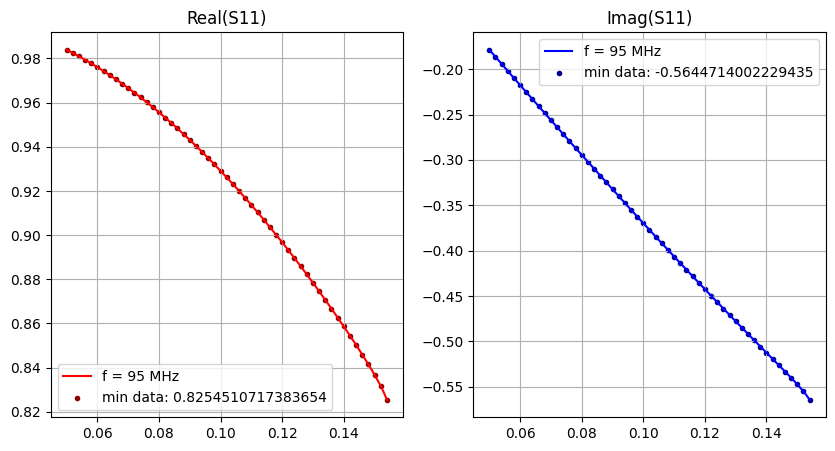

In [3]:
# plot the capacitor
lengths = np.linspace(0.05, 0.154, 1000)
S11_array = np.zeros_like(lengths, dtype='complex')
f = 95

for i in range(lengths.shape[0]):
    l = lengths[i]
    capnet = myrfTWA.build_capnet_given_length_interpolated(length=l, freqs=myrfTWA.freqs_for_fullant)
    i_f = np.where(myrfTWA.freqs_for_fullant == f)
    S11 = capnet.s[i_f][0][0][0]
    S11_array[i] = S11
    if i ==0:
        print(S11)
print(S11_array.shape)
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(lengths, np.real(S11_array), label=f'f = {f} MHz', color='red')
ax[1].plot(lengths, np.imag(S11_array), label=f'f = {f} MHz', color='blue')


ax[0].grid()
ax[1].grid()

ax[0].set_title('Real(S11)')
ax[1].set_title('Imag(S11)')


# raw data 
file_name = 'circ_model/S11_cap_90to102MHz_16cm_capbox_og_width_touse.csv'
length_data = np.arange(0.05, 0.156, 0.002)
S11_found = np.zeros_like(length_data, dtype='complex')
lfound = np.zeros_like(length_data, dtype='complex')
for i in range(length_data.shape[0]):
    ffound, lcapfound, S11, S11db, Z0_port, VSWR = myrfTWA.get_cap_S_given_f_and_lcap(filename=file_name,
                                                                                       f=f, lcap=length_data[i], round_level=3)
    S11_found[i] = S11
    lfound[i] = lcapfound

ax[0].scatter(length_data, np.real(S11_found), marker='.', color='darkred', label=f'min data: {np.min(np.real(S11_found))}')
ax[1].scatter(length_data, np.imag(S11_found), marker='.', color='darkblue', label=f'min data: {np.min(np.imag(S11_found))}')
ax[0].legend()
ax[1].legend()


In [4]:
myrfTWA.captable[0,:]

array([ 8.10000000e+01 +0.j        ,  5.00000000e-02 +0.j        ,
        8.10000000e+01 +0.j        ,  8.47006090e-01 -0.5315835j ,
        1.46230911e-06 +0.j        ,  9.88312899e-01 -0.15243999j,
       -1.02893943e-05-32.48900062j,  9.33990163e+00 +0.j        ,
       -1.18796903e+07 +0.j        ])

In [5]:
# Testing out the differential evolution optimization method 
# confirm class version works 

bounds = [(0.05, 0.154)]*5#[(0.02, 0.095)]*5
freq_bounds = (92, 100)
s11cutoff = -35

res = myrfTWA.run_differential_evolution_global_op(bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq_bounds=freq_bounds,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.08849023 0.09599228 0.14993422 0.15234906 0.05880822]
[0.08849022732688945, 0.09599228401971263, 0.1499342238930328, 0.15234905753668626, 0.058808221592512804, 0.15234905753668626, 0.1499342238930328, 0.09599228401971263, 0.08849022732688945]
Average absolute error is : 1.12e+04
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.13459133 0.06952576 0.14387354 0.06398663 0.14675976]
[0.13459132866662066, 0.0695257579363131, 0.1438735435548728, 0.06398663230925734, 0.14675976159703202, 0.06398663230925734, 0.1438735435548728, 0.0695257579363131, 0.13459132866662066]
Average absolute error is : 1.10e+04
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.06102419 0.0640463  0.08323962 0.12100302 0.06698848]
[0.061024187292588516, 0.06404630069416871, 0.08323962484294549, 0.12100301628383633, 0.06698847991145279, 0.12100301628383633, 0.0832396248429454

final lengths: [0.11910201107244842, 0.08420869496041361, 0.061454851440465495, 0.09707869002113341, 0.12383755650263331]
[0.11910201107244842, 0.08420869496041361, 0.061454851440465495, 0.09707869002113341, 0.12383755650263331, 0.09707869002113341, 0.061454851440465495, 0.08420869496041361, 0.11910201107244842]


C:\Users\jacob\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


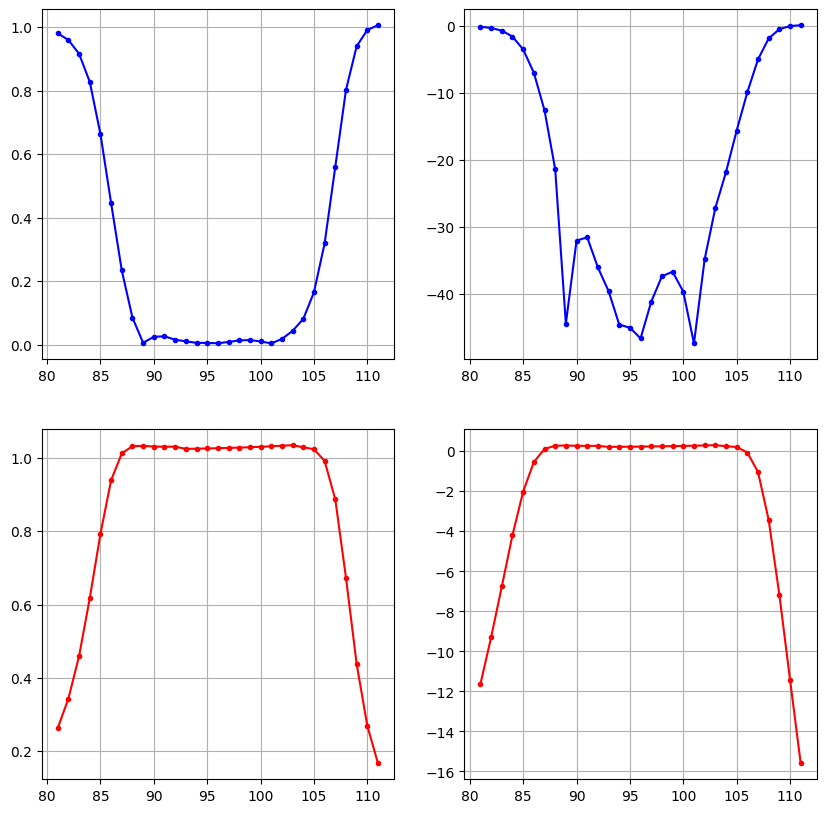

In [6]:
lengths_found = res.x.tolist()
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found, symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].grid()
ax[1,1].grid()

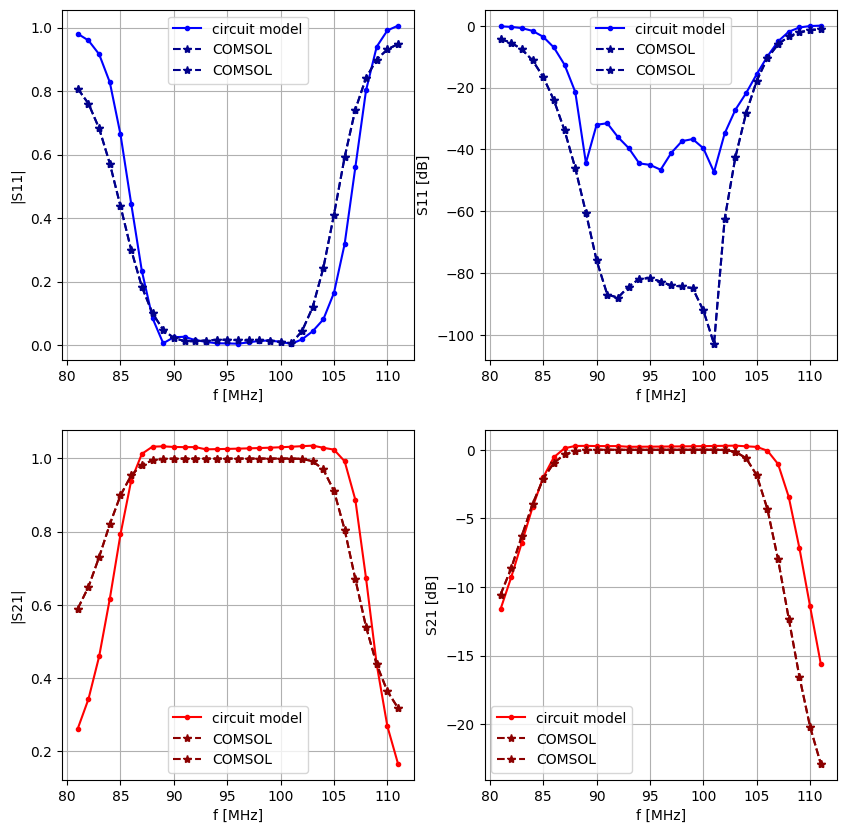

In [7]:
# now plot the solution next to the data
# load up full comsol model's scan 
filename = 'circ_model/fscan_longer_caps_v1.csv'
#filename = 'circ_model/fscan_10_25_fullant.csv'
dataset, headers = myrfTWA.get_comsol_datatable(filename)
fd = dataset[:, 0]
S11d = dataset[:,1]
S21d = dataset[:,2]

S11d_mag = np.abs(S11d)
S21d_mag = np.abs(S21d)

S11d_db = 20*np.log(S11d_mag)
S21d_db = 20*np.log(S21d_mag)


fig, ax = plt.subplots(2,2,figsize=(10,10))

# plot optimization circuit
ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue', label='circuit model')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue', label='circuit model')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red', label='circuit model')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red', label='circuit model')
ax[1,0].grid()
ax[1,1].grid()

# plot data

ax[0,0].plot(fd, S11d_mag, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[0,1].plot(fd, S11d_db, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[1,0].plot(fd, S21d_mag, marker='*', color='darkred', label='COMSOL',linestyle='--')
ax[1,1].plot(fd, S21d_db, marker='*', color='darkred', label='COMSOL',linestyle='--')
ax[0,0].plot(fd, S11d_mag, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[0,1].plot(fd, S11d_db, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[1,0].plot(fd, S21d_mag, marker='*', color='darkred', label='COMSOL',linestyle='--')
ax[1,1].plot(fd, S21d_db, marker='*', color='darkred', label='COMSOL',linestyle='--')

ax[0,0].set_xlabel('f [MHz]')
ax[0,1].set_xlabel('f [MHz]')
ax[1,0].set_xlabel('f [MHz]')
ax[1,1].set_xlabel('f [MHz]')

ax[0,0].set_ylabel('|S11|')
ax[0,1].set_ylabel('S11 [dB]')
ax[1,0].set_ylabel('|S21|')
ax[1,1].set_ylabel('S21 [dB]')

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

In [8]:
# now trying differential evolution with the pure capacitor model 

bounds = [(5.3656e-12, 60e-12)]*5
freq_bounds = (93, 98)
s11cutoff = -35

res2 = myrfTWA.run_differential_evolution_global_op_explicitC(bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq_bounds=freq_bounds,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False)

----------------------------------------
i_iter = 1
New simulation.
Point is: [3.32649001e-11 1.98698212e-11 2.52626317e-11 2.39430700e-11
 1.01781517e-11]
Average absolute error is : 7.08e+03
----------------------------------------
i_iter = 2
New simulation.
Point is: [1.91965782e-11 5.09183962e-11 1.26581328e-11 1.20229452e-11
 1.24660299e-11]
Average absolute error is : 7.35e+03
----------------------------------------
i_iter = 3
New simulation.
Point is: [3.75112514e-11 5.65890270e-11 1.58389068e-11 4.54448769e-11
 3.52750146e-11]
Average absolute error is : 7.35e+03
----------------------------------------
i_iter = 4
New simulation.
Point is: [5.48709930e-11 2.86352039e-11 2.01150647e-11 2.99913402e-11
 1.31441642e-11]
Average absolute error is : 6.68e+03
----------------------------------------
i_iter = 5
New simulation.
Point is: [5.73406832e-11 2.00687277e-11 1.23020135e-11 2.88961653e-11
 1.76632809e-11]
Average absolute error is : 6.76e+03
-----------------------------------

final Cs: [46.83153495 32.05789691 24.16977372 33.32318864 37.05053598] pF


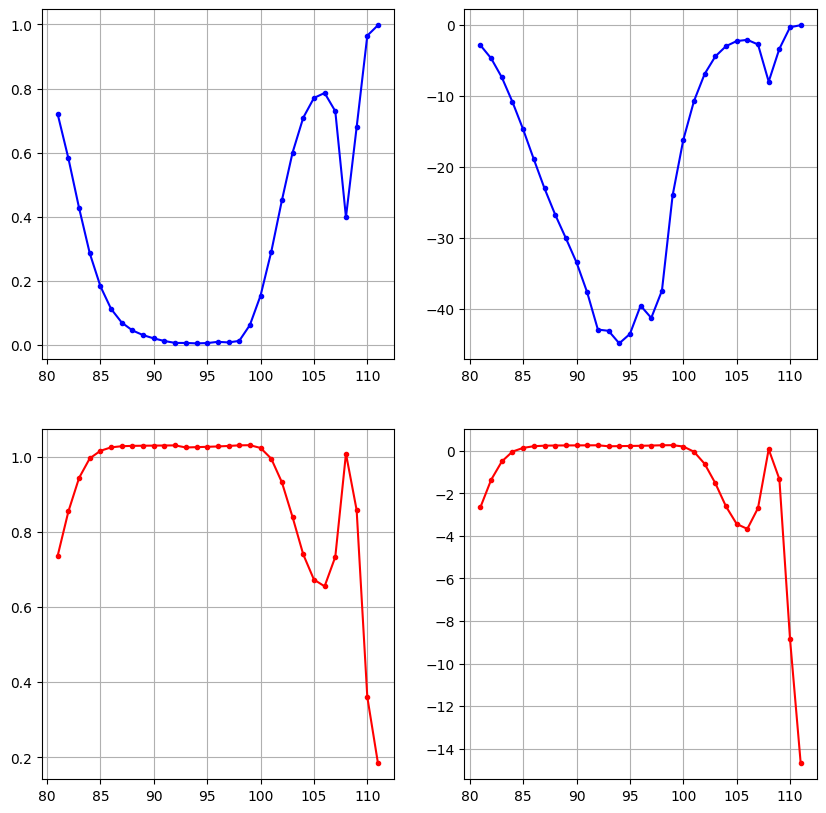

In [9]:
Cs_found = res2.x.tolist()
#Cs_found = [42.59722182, 28.77599259, 21.77324347, 29.38619356, 31.11430196]
print('final Cs:', np.array(Cs_found)*1e12, 'pF')
full_net_optimized = myrfTWA.get_fullant_given_Cs_via_caps_from_internal_datatable(Cs_found, symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].grid()
ax[1,1].grid()

In [58]:
# figure out what length corrisponds to what capacitance
# optimize with a capacitor C object instead of lengths and see if they match up 
lmin = 0.05
lmax = 0.154#0.095
fi = 96
capmin = myrfTWA.build_capnet_given_length_from_internal_datatable(length=lmin, freqs=np.array([fi]))
zcapmin, Cmin = myrfTWA.print_znorm_and_capacitance(capmin, fi, toprint=True)
capmax = myrfTWA.build_capnet_given_length_from_internal_datatable(length=lmax, freqs=np.array([fi]))
zcapmax, Cmax = myrfTWA.print_znorm_and_capacitance(capmax, fi, toprint=True)
m = (Cmax - Cmin)*1e12/(lmax - lmin)
b = Cmax*1e12 - m*lmax
print(m)
print(b)

lget = 0.05
print(m*lget + b)

Zcap:(0.0019835242279406477-102.8226046402893j), z0: [9.3506+0.j], Zcap/z0: [0.00021213-10.99636437j]
C = 16.12353622377477 pF
Zcap:(6.605335561681456e-05-29.90435428561749j), z0: [9.3506+0.j], Zcap/z0: [7.0640767e-06-3.19812143j]
C = 55.43888273614812 pF
378.03217800358993
-2.778072676404726
16.12353622377477


In [11]:
# calculating new seperation distance 

n_op = 3.5245#3.1832#1.8079
f = 96e6
w = 2*np.pi*f
clight = 3e8
dold = 0.15625
dphi_new = n_op*(w*dold)/clight
print('dphi_new', dphi_new/np.pi, 'pi')
print(dphi_new*180/np.pi, 'deg')
npar_target = 5
d_new = dphi_new*clight/(npar_target*w)
print('d_new', d_new)

szpp = 10.25e-2
npar_pp = dphi_new*clight/(szpp*w)
kpp = dphi_new/szpp
print(npar_pp)
print(kpp)

dphi_new 0.35245000000000004 pi
63.44100000000001 deg
d_new 0.110140625
5.372713414634147
10.8024812756851


In [65]:
# Testing out the differential evolution optimization method with same caps being enforced 
# confirm class version works 

bounds = [(0.05, 0.154)]*5#[(0.02, 0.095)]*5
freq_bounds = (92, 100)
s11cutoff = -35
beta=70#65

res = myrfTWA.run_differential_evolution_global_op_l_matters(bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq_bounds=freq_bounds,
                                            beta_length_op=beta,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.13709895 0.08562973 0.1422006  0.11564728 0.07914664]
[0.1370989468258445, 0.08562972713750948, 0.14220060453105762, 0.1156472840564465, 0.07914664053244336, 0.1156472840564465, 0.14220060453105762, 0.08562972713750948, 0.1370989468258445]
Average absolute error is : 1.09e+04
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.06963384 0.08335609 0.14599031 0.07831156 0.09051167]
[0.06963384049744048, 0.08335609279413168, 0.14599031203832152, 0.0783115587816422, 0.09051166908768861, 0.0783115587816422, 0.14599031203832152, 0.08335609279413168, 0.06963384049744048]
Average absolute error is : 1.28e+04
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.0910776  0.08803843 0.05113534 0.10577401 0.14125838]
[0.09107759897321704, 0.08803843209329598, 0.05113534144659397, 0.10577400902414161, 0.14125837581994874, 0.10577400902414161, 0.05113534144659397,

final lengths: [0.12713702242164984, 0.0905852585614057, 0.08731772281347729, 0.12012812640377653, 0.1277804639066831]
[0.12713702242164984, 0.0905852585614057, 0.08731772281347729, 0.12012812640377653, 0.1277804639066831, 0.12012812640377653, 0.08731772281347729, 0.0905852585614057, 0.12713702242164984]


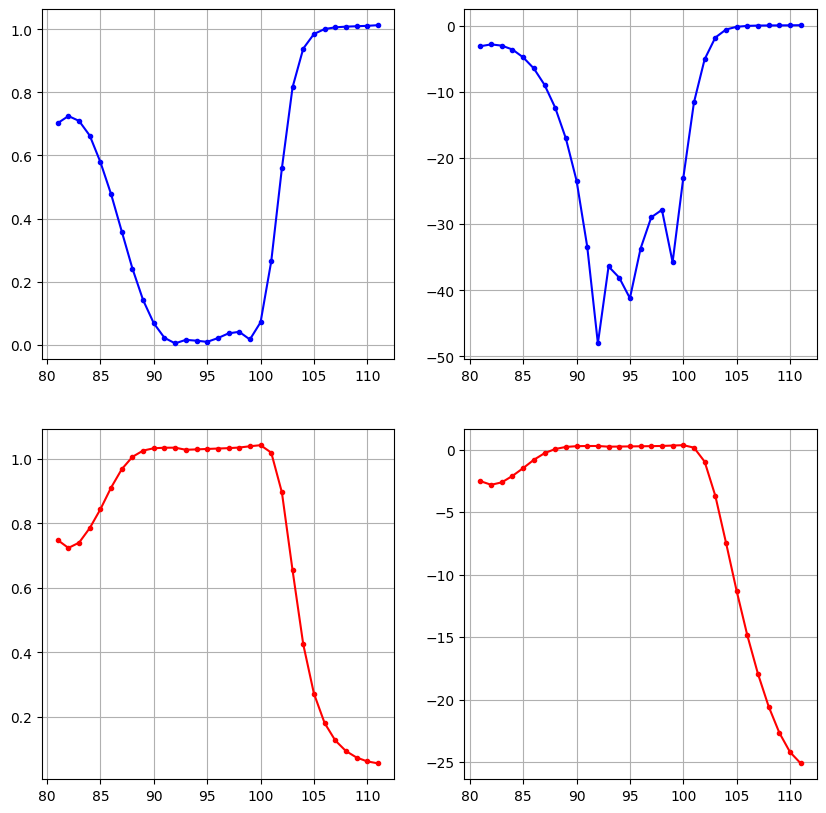

In [70]:
lengths_found = res.x.tolist()
lsmall = 0.002#-.05e-2
#TODO REMOVE
lengths_found = (np.array(lengths_found) + lsmall).tolist()
##
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found, symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].grid()
ax[1,1].grid()